# Amita's Code

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import math
import random
import pickle


**random seed added for easier training**

In [3]:
np.random.seed(42)  # Example seed for reproducibility

In [ ]:
class UAVEnv(object):
    def __init__(self, num_uavs=3):
        #number of UAVS
        self.num_uavs = num_uavs
        #Dimensions of the environment
        self.height = self.ground_length = self.ground_width = 100
        # total size of task to be offloaded
        self.sum_task_size = 100 * 1048576
        # uav height fixed, initial positions of the UAv
        self.loc_uav = np.array([[0, 0] for _ in range(num_uavs)])
        # Number of Bandwidths units available
        self.bandwidth_nums = 1
        # Total Bandwidth 
        self.B = self.bandwidth_nums * 10 ** 8
        #Noise Power in Line-of-Sight Conditions
        self.p_noisy_los = 10 ** (-13)
        #Noise power in Non-Line of Sight conditions 
        self.p_noisy_nlos = 10 ** (-8)
        # Noise power
        self.noise_power_squared=10**-10
        #Uav Speed
        self.flight_speed = 50.
        # calculation CPU frequency of user 
        self.f_ue = 4e4
        #calculation Cpu frequency of UAV
        self.f_uav = 1.2e5
        # r is the energy consumption coefficient
        self.r = 10 ** (-17)
        # Task size unit
        self.s = 1000
        # Uplink transmission Power
        self.p_uplink = 0.1
        #path loss exponent
        self.alpha0 = -30
        #T is the Total Time Duration
        self.T = 320
        # t_fly,t_com is the Time for flying and communication 
        self.t_fly = 1
        self.t_com = 7
        #Time slot duration
        self.delta_t = self.t_fly + self.t_com
        # number of time slots 
        self.slot_num = int(self.T / self.delta_t)
        # mass of UAV
        self.m_uav = 9.65
        #Initial UAV battery range 
        self.e_battery_uav = 500000
        # Number of User devices 
        self.M = 100
        # array indicating whether a user device is blocked or not 
        self.block_flag_list = np.random.uniform(0, 0.3, self.M)
        #Locations of user devices 
        self.loc_ue_list = np.random.randint(0, 30, size=[self.M, 2])
        for i in range(self.M//4):
            self.loc_ue_list[i] = [np.random.randint(90,100), np.random.randint(90,100)]
        # Sizes for task for each UE
        self.task_list = np.random.randint(1*10**5, 2*10**5, self.M)
        # Dimensionality of state space where M is the number of user devices
        self.state_dim = 4 + self.M * 4
        self.state_space_dim = self.state_dim
        #Dimensionaltiy of the action space
        self.action_dim = 4
        #Transition Probabilities for User device locations
        self.loc_ue_trans_pro = np.array([[.6, .1, .1, .1, .1],
                                        [.6, .1, .1, .1, .1],
                                        [.6, .1, .1, .1, .1],
                                        [.6, .1, .1, .1, .1]])
        #The limit under which every action is constrained
        self.action_bound = [-1, 1]

        # Start_state is the initial state of the environment 
        self.start_state = np.append(self.e_battery_uav, self.loc_uav.flatten())
        self.start_state = np.append(self.start_state, self.sum_task_size)
        self.start_state = np.append(self.start_state, np.ravel(self.loc_ue_list))
        self.start_state = np.append(self.start_state, self.task_list)
        self.start_state = np.append(self.start_state, self.block_flag_list)
        # state is the current state
        self.state = self.start_state
        

    def step(self,actions):
        is_terminal = False
        rewards = np.zeros(self.num_uavs)
        step_redos = np.zeros(self.num_uavs, dtype=bool)
        offloading_ratios = np.zeros(self.num_uavs)
        reset_dists = np.zeros(self.num_uavs)
        throughputs = np.zeros(self.num_uavs)
        Time_ = np.zeros(self.num_uavs)
        power_ = np.zeros(self.num_uavs)
    
        for i in range(self.num_uavs):
            action = np.clip((actions[i] + 1) / 2, 0, 1)
            action = np.nan_to_num(action, nan=0.0)
    
            ue_id = int(self.M * action[0]) % self.M
            theta = float(action[1] * np.pi * 2)
            offloading_ratio = action[2]
            offloading_ratios[i] = offloading_ratio
    
            task_size = self.task_list[ue_id]
            block_flag = self.block_flag_list[ue_id]
    
            dis_fly = action[3] * self.flight_speed * self.t_fly
            e_fly = (dis_fly / self.t_fly) ** 2 * self.m_uav * self.t_fly * 0.05
    
            dx_uav = dis_fly * math.cos(theta)
            dy_uav = dis_fly * math.sin(theta)
            
            # Ensure UAV stays within boundaries
            loc_uav_after_fly_x = np.clip(self.loc_uav[i][0] + dx_uav, 0, self.ground_width)
            loc_uav_after_fly_y = np.clip(self.loc_uav[i][1] + dy_uav, 0, self.ground_length)
    
            t_server = task_size * offloading_ratio / self.f_uav
            t_ue = task_size * (1 - offloading_ratio) / self.f_ue
            energy_server = self.r * self.f_uav ** 3 * t_server * 10
            energy_local = self.r * self.f_ue ** 3 * t_ue * 10
    
            if self.sum_task_size == 0:
                is_terminal = True
                rewards[i] = 0
            elif self.sum_task_size - task_size < 0:
                self.task_list = np.ones(self.M) * self.sum_task_size
                rewards[i] = 0
                step_redos[i] = True
            elif self.e_battery_uav < e_fly or self.e_battery_uav - e_fly < energy_server:
                rewards[i] = -5
            else:   
                dx = self.loc_ue_list[ue_id][0] - loc_uav_after_fly_x
                dy = self.loc_ue_list[ue_id][1] - loc_uav_after_fly_y
                dh = self.height
                dist = np.sqrt(dx ** 2 + dy ** 2 + dh ** 2)
                x_rand = np.random.randn()
                h_val = 1 / (1 + (dist / 100)**2)**2 * (x_rand**2 + 1)
                p_tran = self.p_uplink * h_val
                alpha = self.alpha0 / (1 + self.height / (dist + 1e-6))**2
                noise_term = self.p_noisy_los * block_flag + self.p_noisy_nlos * (1 - block_flag)
                sinr = np.clip(p_tran * alpha / noise_term, 1e-10, None)
                
                local_execution_delay, transmission_delay, server_execution_delay = self.com_delay(self.loc_ue_list[ue_id], np.array([loc_uav_after_fly_x, loc_uav_after_fly_y]),offloading_ratio, task_size, block_flag)
                
                throughputs[i] = self.throughput(self.loc_ue_list[ue_id],np.array([loc_uav_after_fly_x, loc_uav_after_fly_y]),offloading_ratio, task_size, block_flag)
                
                e_fly = e_fly / 10 if offloading_ratio > 0 else 0
                energy = e_fly + energy_server + energy_local
                delay = (local_execution_delay * (1 - offloading_ratio) +server_execution_delay * offloading_ratio +transmission_delay * offloading_ratio)
                
                power_[i] = energy
                Time_[i] = delay
                reward = -(energy + delay)
    
                rewards[i] = reward
                self.e_battery_uav -= energy
                self.sum_task_size -= task_size
                
                # Update UAV location
                self.loc_uav[i] = [loc_uav_after_fly_x, loc_uav_after_fly_y]
    
        self.update_ue_locations()
        self.reset_step()
    
        reset_dists = np.linalg.norm(self.loc_uav - np.array([[0, 0] for _ in range(self.num_uavs)]), axis=1)
    
        return (self._get_obs(), rewards, is_terminal, step_redos, offloading_ratios, reset_dists, throughputs, Time_, power_)
    
    def update_ue_locations(self):
        for j in range(self.M):
            tmp = np.random.rand()
            if tmp <= 0.6:
                pass
            elif 0.6 < tmp <= 0.7:
                self.loc_ue_list[j] += [0, 1]
            elif 0.7 < tmp <= 0.8:
                self.loc_ue_list[j] += [1, 0]
            elif 0.8 < tmp <= 0.9:
                self.loc_ue_list[j] += [0, -1]
            else:
                self.loc_ue_list[j] += [-1, 0]
            self.loc_ue_list[j] = np.clip(self.loc_ue_list[j], 0, 100)
        self.reset_step()
        
# Resets the environment to its initial state
    def reset(self):
        self.reset_env()
        self.state = np.append(self.e_battery_uav, self.loc_uav.flatten())
        self.state = np.append(self.state, self.sum_task_size)
        self.state = np.append(self.state, np.ravel(self.loc_ue_list))
        self.state = np.append(self.state, self.task_list)
        self.state = np.append(self.state, self.block_flag_list)
        return self._get_obs()
    
# Resets Specific environment parameters

    def reset_env(self):
        self.sum_task_size = 100 * 1048576
        self.e_battery_uav = 500000
        self.loc_uav = np.array([[0, 0] for _ in range(self.num_uavs)])
        for i in range(2):
            self.loc_ue_list[i] = [np.random.randint(0,100), np.random.randint(0,100)]
        self.reset_step()
# Resets Task related parameters 
    def reset_step(self):
        self.task_list = np.random.randint(2621440, 3145729, self.M)
        self.block_flag_list = np.random.uniform(0, 0.3, self.M)

    def _get_obs(self):
        self.state = np.append(self.e_battery_uav, self.loc_uav.flatten())
        self.state = np.append(self.state, self.sum_task_size)
        self.state = np.append(self.state, np.ravel(self.loc_ue_list))
        self.state = np.append(self.state, self.task_list)
        self.state = np.append(self.state, self.block_flag_list)
        return self.state
    
    def com_delay(self, loc_ue, loc_uav, offloading_ratio, task_size, block_flag):
        # Calculate Euclidean distance between UE and UAV
        dx = loc_uav[0] - loc_ue[0]
        dy = loc_uav[1] - loc_ue[1]
        dh = self.height  # UAV height relative to ground
        dist = np.sqrt(dx**2 + dy**2 + dh**2)
        fading_factor=1

        if dist!=0:
            channel_gain=(10**-5)/dist
        else:
            channel_gain=100
        snr=float((self.p_uplink*channel_gain*fading_factor)/(self.noise_power_squared+self.p_noisy_nlos))
        snr=round(snr,2)
        transmission_rate=float((self.B*math.log2(1+snr)))
        # Communication delay calculation
        if transmission_rate==0:
            transmission_delay=float('inf')
        else:
            transmission_delay=task_size/transmission_rate
        transmission_delay=transmission_delay+block_flag*transmission_delay
        local_execution_delay = task_size/ (self.f_ue)
        server_execution_delay=task_size/(self.f_uav)
        
        return local_execution_delay/2,transmission_delay*500,server_execution_delay/2

    # Calculates the throughput of the communication link 
    def throughput(self, loc_ue, loc_uav, offloading_ratio, task_size, block_flag):
        local_execution_delay,transmission_delay,server_execution_delay=self.com_delay(loc_ue, loc_uav, offloading_ratio, task_size, block_flag)
        delay=local_execution_delay*(1-offloading_ratio)*2+(transmission_delay*offloading_ratio)/500+server_execution_delay*offloading_ratio*2
        return task_size /delay


# Enhanced code with LSTM

Episode: 1
Total Reward for Episode 1: -1862.8322311331199
Episode: 2
Total Reward for Episode 2: -1693.1820648530029
Episode: 3
Total Reward for Episode 3: -2351.307433299478
Episode: 4
Total Reward for Episode 4: -3462.8871074503695
Episode: 5
Total Reward for Episode 5: -2476.928835366462
Episode: 6
Total Reward for Episode 6: -2557.5363442290936
Episode: 7
Total Reward for Episode 7: -2170.3992411260965
Episode: 8
Total Reward for Episode 8: -2115.97976304564
Episode: 9
Total Reward for Episode 9: -2662.485497667605
Episode: 10
Total Reward for Episode 10: -2108.1970475409275
Episode: 11
Total Reward for Episode 11: -1816.7279340844295
Episode: 12
Total Reward for Episode 12: -2256.5098241894198
Episode: 13
Total Reward for Episode 13: -2298.4510003117125
Episode: 14
Total Reward for Episode 14: -2344.824438385114
Episode: 15
Total Reward for Episode 15: -2311.857323105027
Episode: 16
Total Reward for Episode 16: -1918.1521217104753
Episode: 17
Total Reward for Episode 17: -1799.12

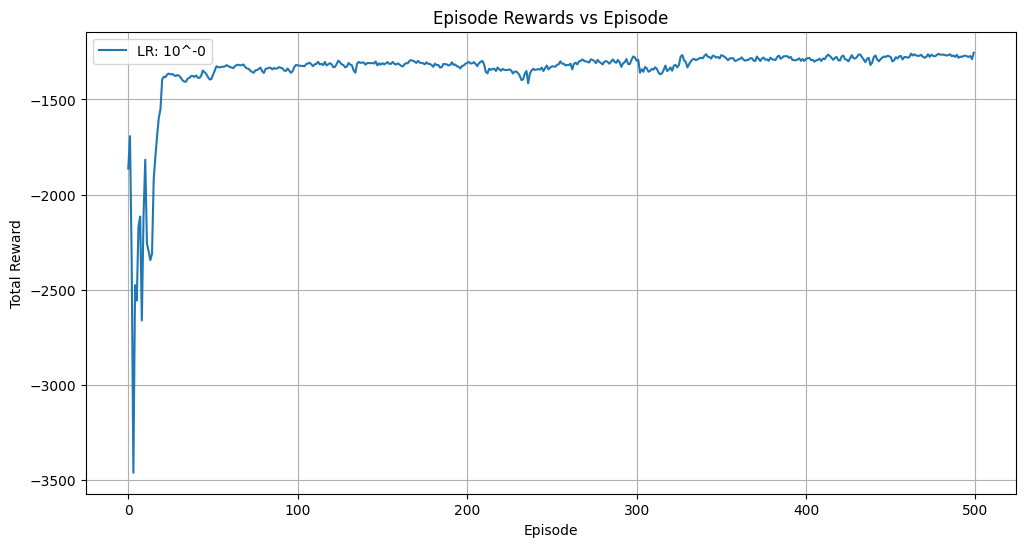

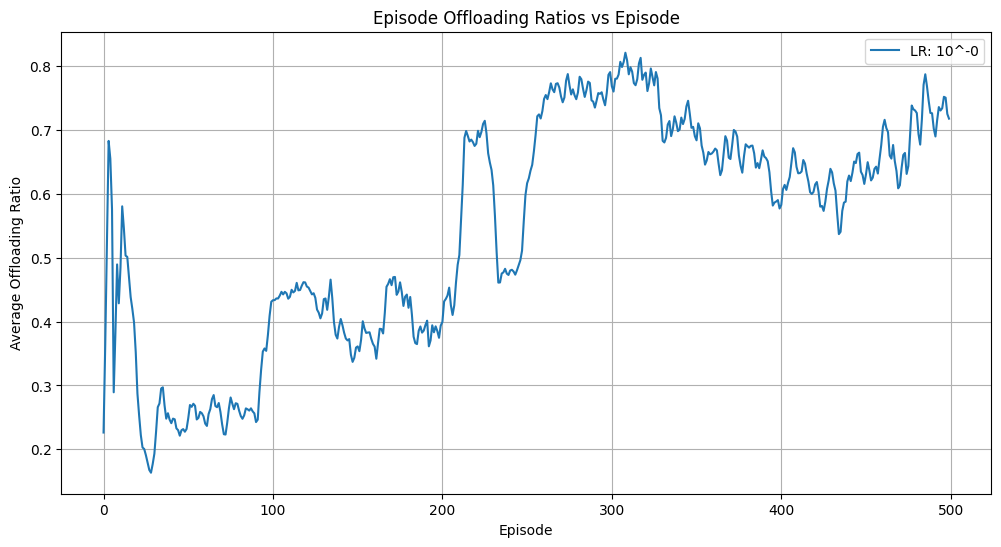

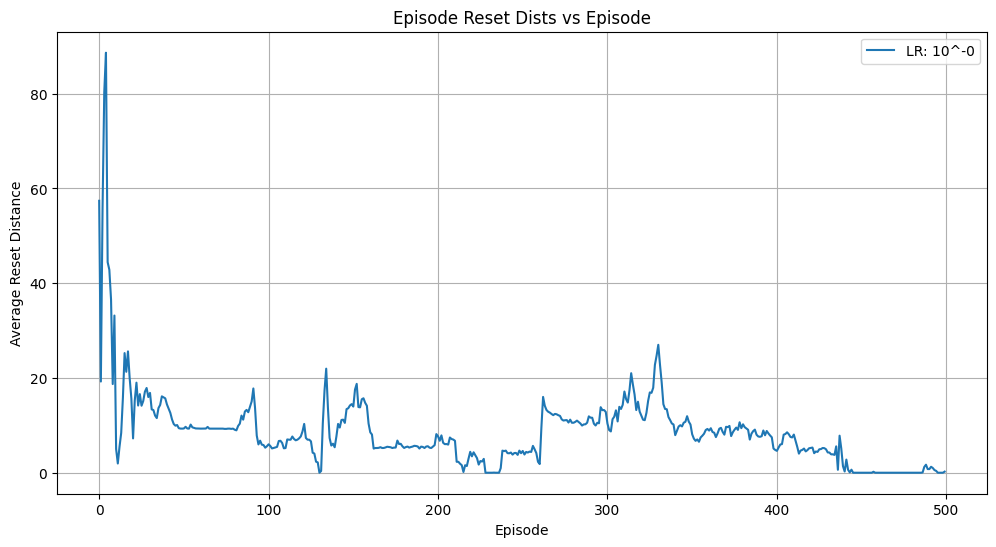

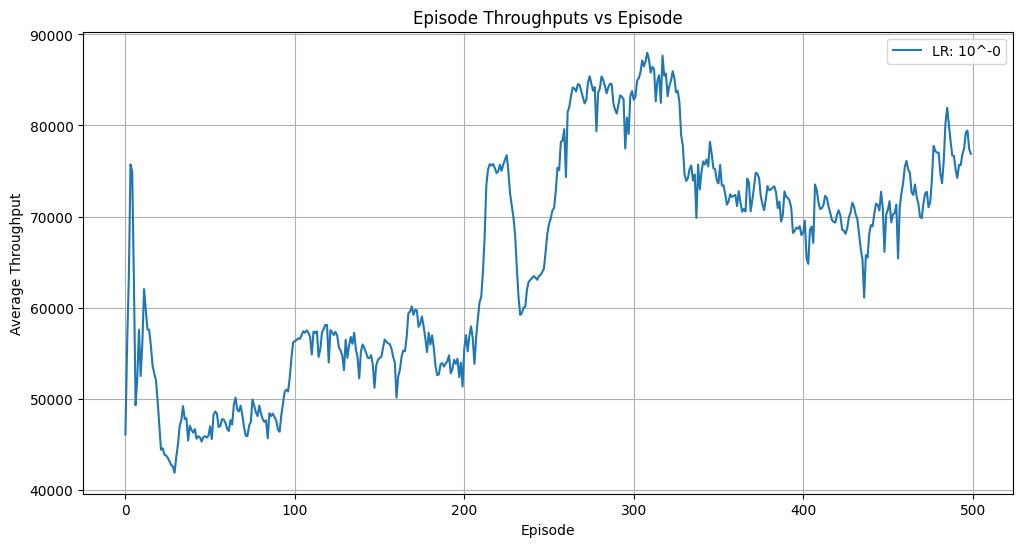

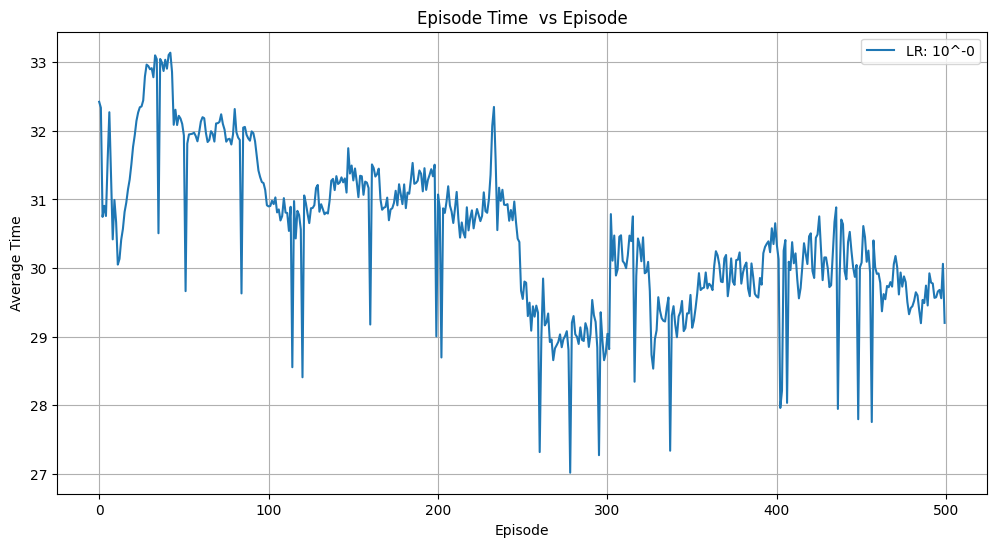

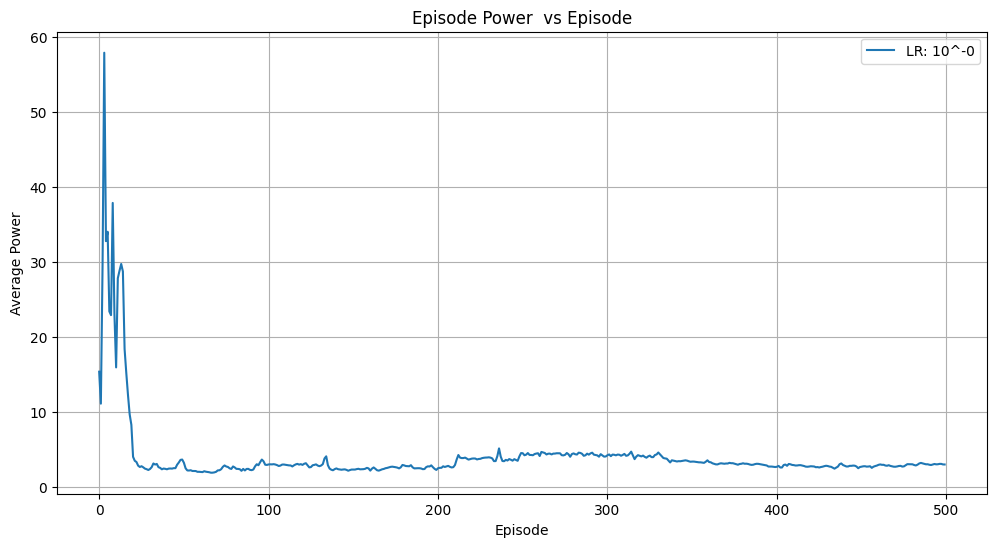

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Enhanced Ornstein-Uhlenbeck Noise for better exploration
class OrnsteinUhlenbeckNoise:
    def __init__(self, size, mu=0, theta=0.15, sigma=0.5, decay=0.99):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma * np.ones(size)
        self.size = size
        self.state = np.ones(self.size) * self.mu
        self.decay = decay  # Decay sigma over time

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.size)
        self.state += dx
        self.sigma *= self.decay  # Gradually reduce noise
        return self.state

# Improved Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)  # Increased capacity
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_dim)
        self.action_bound = action_bound
        self.dropout = nn.Dropout(0.2)  # Prevent overfitting

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        action = torch.tanh(self.fc4(x)) * self.action_bound[1]
        return action

# Improved Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 512)  # Increased capacity
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        q_value = self.fc4(x)
        return q_value

# Enhanced DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic):
        self.actor = Actor(state_dim, action_dim, action_bound)
        self.actor_target = Actor(state_dim, action_dim, action_bound)
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate_actor, weight_decay=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=learning_rate_critic, weight_decay=1e-4)
        self.criterion = nn.MSELoss()
        self.gamma = 0.99
        self.tau = 0.01  # Increased for faster target updates
        self.noise = OrnsteinUhlenbeckNoise(action_dim)
        self.update_target_network(tau=1.0)

    def choose_action(self, state, episode, max_episodes):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state).numpy().flatten()
        # Add exploration noise with decay
        exploration_scale = max(0, 1 - episode / (max_episodes * 0.5))
        return np.clip(action + self.noise.sample() * exploration_scale, self.actor.action_bound[0], self.actor.action_bound[1])

    def update_target_network(self, tau=None):
        tau = tau if tau is not None else self.tau
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def train(self, replay_buffer, batch_size):
        if len(replay_buffer.buffer) < batch_size:
            return

        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)
        reward = torch.FloatTensor(reward).unsqueeze(1)
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor(done).unsqueeze(1)

        target_q = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + (1 - done) * self.gamma * target_q
        current_q = self.critic(state, action)
        critic_loss = self.criterion(current_q, target_q.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()

        self.update_target_network()

# Replay Buffer (unchanged)
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

# Enhanced LSTM Refiner
class LSTMRefiner(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LSTMRefiner, self).__init__()
        self.lstm = nn.LSTM(input_dim, 256, num_layers=2, batch_first=True, dropout=0.2)  # Increased capacity
        self.fc = nn.Linear(256, output_dim)

    def forward(self, state):
        state = state.unsqueeze(0)
        out, _ = self.lstm(state)
        out = self.fc(out[:, -1, :])
        return out

    def refine_state(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        refined_state = self.forward(state).detach().numpy().flatten()
        return refined_state

# Refined DDPG Agent
class DDPGRefinedAgent(DDPGAgent):
    def __init__(self, state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic):
        super(DDPGRefinedAgent, self).__init__(state_dim, action_dim, action_bound, learning_rate_actor, learning_rate_critic)
        self.refiner = LSTMRefiner(state_dim, state_dim)

    def choose_action(self, state, episode, max_episodes):
        refined_state = self.refiner.refine_state(state)
        return super().choose_action(refined_state, episode, max_episodes)

def pad_state(state, target_dim):
    return np.pad(state, (0, target_dim - len(state)), 'constant')

# Optimized Training Loop
def train_agents(env, num_episodes=500):
    num_uavs = env.num_uavs
    s_dim = max(env.state_dim, 20)
    a_dim = env.action_dim

    all_metrics = {
        'episode_rewards': {},
        'episode_offloading_ratios': {},
        'episode_reset_dists': {},
        'episode_throughputs': {},
        'episode_Time_': {},
        'episode_power_': {}
    }

    for i in range(1):  # Single learning rate for simplicity, adjust as needed
        lr_actor = 1e-4  # Fixed learning rate with annealing
        lr_critic = 1e-3
        agents = [DDPGAgent(s_dim, a_dim, env.action_bound, lr_actor, lr_critic) for _ in range(num_uavs)]
        lstm_refiners = [LSTMRefiner(s_dim, s_dim) for _ in range(num_uavs)]
        refined_agents = [DDPGRefinedAgent(s_dim, a_dim, env.action_bound, lr_actor, lr_critic) for _ in range(num_uavs)]
        replay_buffers = [ReplayBuffer(max_size=200000, state_dim=s_dim, action_dim=a_dim) for _ in range(num_uavs)]  # Larger buffer

        episode_rewards = []
        episode_offloading_ratios = []
        episode_reset_dists = []
        episode_throughputs = []
        episode_Time_ = []
        episode_power_ = []

        for episode in range(num_episodes):
            print(f"Episode: {episode + 1}")
            state = env.reset()
            episode_reward = 0
            offloading_ratios = []
            reset_dists = []
            throughputs = []
            Time_ = []
            power_ = []

            while True:
                actions = []
                for j in range(num_uavs):
                    uav_state = state[j * s_dim:(j + 1) * s_dim]
                    uav_state = pad_state(uav_state, s_dim)
                    refined_state = lstm_refiners[j].refine_state(uav_state)
                    final_action = refined_agents[j].choose_action(refined_state, episode, num_episodes)
                    actions.append(final_action)

                next_state, rewards, is_terminal, step_redos, offloading_ratios_step, reset_dists_step, throughputs_step, Time_step, power_step = env.step(actions)

                for j in range(num_uavs):
                    uav_state = pad_state(state[j * s_dim:(j + 1) * s_dim], s_dim)
                    refined_state = lstm_refiners[j].refine_state(uav_state)
                    uav_next_state = pad_state(next_state[j * s_dim:(j + 1) * s_dim], s_dim)
                    refined_next_state = lstm_refiners[j].refine_state(uav_next_state)
                    replay_buffers[j].store(refined_state, actions[j], rewards[j], refined_next_state, step_redos[j])
                    agents[j].train(replay_buffers[j], batch_size=128)  # Larger batch size
                    refined_agents[j].train(replay_buffers[j], batch_size=128)

                state = next_state
                episode_reward += np.nansum(rewards)

                offloading_ratios.append(np.mean(offloading_ratios_step))
                reset_dists.append(np.mean(reset_dists_step))
                throughputs.append(np.mean(throughputs_step))
                Time_.append(np.mean(Time_step))
                power_.append(np.mean(power_step))

                if is_terminal:
                    break

            episode_rewards.append(episode_reward)
            episode_offloading_ratios.append(np.mean(offloading_ratios))
            episode_reset_dists.append(np.mean(reset_dists))
            episode_throughputs.append(np.mean(throughputs))
            episode_Time_.append(np.mean(Time_))
            episode_power_.append(np.mean(power_))
            print(f"Total Reward for Episode {episode + 1}: {episode_reward}")

        lr_key = f'10^-{i}'
        all_metrics['episode_rewards'][lr_key] = episode_rewards
        all_metrics['episode_offloading_ratios'][lr_key] = episode_offloading_ratios
        all_metrics['episode_reset_dists'][lr_key] = episode_reset_dists
        all_metrics['episode_throughputs'][lr_key] = episode_throughputs
        all_metrics['episode_Time_'][lr_key] = episode_Time_
        all_metrics['episode_power_'][lr_key] = episode_power_

    return all_metrics

# Plotting functions (unchanged)
def plot_all_learning_rates(all_metrics, metric_name, ylabel):
    plt.figure(figsize=(12, 6))
    for lr, values in all_metrics[metric_name].items():
        plt.plot(values, label=f'LR: {lr}')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.title(f'{metric_name.replace("_", " ").title()} vs Episode')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{metric_name}_all_lr.png')
    plt.show()
    plt.close()

# Main execution
if __name__ == "__main__":
    env = UAVEnv(num_uavs=3)  # Assuming UAVEnv is defined elsewhere
    all_metrics = train_agents(env)

    with open('DDPG_with_LSTM_new.pkl', 'wb') as file:
        pickle.dump(all_metrics, file)

    print('All metrics saved successfully')

    plot_all_learning_rates(all_metrics, 'episode_rewards', 'Total Reward')
    plot_all_learning_rates(all_metrics, 'episode_offloading_ratios', 'Average Offloading Ratio')
    plot_all_learning_rates(all_metrics, 'episode_reset_dists', 'Average Reset Distance')
    plot_all_learning_rates(all_metrics, 'episode_throughputs', 'Average Throughput')
    plot_all_learning_rates(all_metrics, 'episode_Time_', 'Average Time')
    plot_all_learning_rates(all_metrics, 'episode_power_', 'Average Power')

<h1>DDPG Without LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.action_bound = action_bound

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.action_bound[1]
        return action

# Critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.relu(self.fc1(torch.cat([state, action], 1)))
        x = torch.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

class DDPGAgent:
    def __init__(self, state_dim, action_dim, action_bound):
        self.actor = Actor(state_dim, action_dim, action_bound)
        self.actor_target = Actor(state_dim, action_dim, action_bound)
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()
        self.gamma = 0.99
        self.tau = 0.001

        # Initialize target networks with actor and critic weights
        self.update_target_network(tau=1.0)

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state).numpy()
        return action.flatten()

    def update_target_network(self, tau=None):
        tau = tau if tau is not None else self.tau
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def train(self, replay_buffer, batch_size):
        if len(replay_buffer.buffer) < batch_size:
            return

        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)
        reward = torch.FloatTensor(reward).unsqueeze(1)
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor(done).unsqueeze(1)

        # Critic update
        target_q = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + (1 - done) * self.gamma * target_q
        current_q = self.critic(state, action)
        critic_loss = self.criterion(current_q, target_q.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self.update_target_network()

class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

def pad_state(state, target_dim):
    return np.pad(state, (0, target_dim - len(state)), 'constant')



# Main training loop
# env = UAVEnv(num_uavs=3)
num_uavs = env.num_uavs
s_dim = max(env.state_dim, 20)
a_dim = env.action_dim
agents = [DDPGAgent(s_dim, a_dim, env.action_bound) for _ in range(num_uavs)]
replay_buffers = [ReplayBuffer(max_size=100000, state_dim=s_dim, action_dim=a_dim) for _ in range(num_uavs)]

# Store episode metrics
episode_rewards = []
episode_offloading_ratios = []
episode_reset_dists = []
episode_throughputs = []
episode_Time_ = []
episode_power_ = []
episode_delays = []
episode_latencies = []

for episode in range(500):
    print(f"Episode: {episode + 1}")
    state = env.reset()
    episode_reward = 0
    offloading_ratios = []
    reset_dists = []
    throughputs = []
    Time_ = []
    power_ = []
    delays = []
    latencies = []
    
    while True:
        actions = []

        for i in range(num_uavs):
            uav_state = state[i * s_dim:(i + 1) * s_dim]
            uav_state = pad_state(uav_state, s_dim)
            action = agents[i].choose_action(uav_state)
            actions.append(action)

        next_state, rewards, is_terminal, step_redos, offloading_ratios_step, reset_dists_step, throughputs_step, Time_step, power_step = env.step(actions)

        for i in range(num_uavs):
            uav_state = state[i * s_dim:(i + 1) * s_dim]
            uav_state = pad_state(uav_state, s_dim)
            uav_next_state = next_state[i * s_dim:(i + 1) * s_dim]
            uav_next_state = pad_state(uav_next_state, s_dim)
            replay_buffers[i].store(uav_state, actions[i], rewards[i], uav_next_state, step_redos[i])
            agents[i].train(replay_buffers[i], batch_size=64)

        state = next_state
        episode_reward += np.nansum(rewards)

        offloading_ratios.append(np.mean(offloading_ratios_step))
        reset_dists.append(np.mean(reset_dists_step))
        throughputs.append(np.mean(throughputs_step))
        Time_.append(np.mean(Time_step))
        power_.append(np.mean(power_step))

        if is_terminal:
            break

    episode_rewards.append(episode_reward)
    episode_offloading_ratios.append(np.mean(offloading_ratios))
    episode_reset_dists.append(np.mean(reset_dists))
    episode_throughputs.append(np.mean(throughputs))
    episode_Time_.append(np.mean(Time_))
    episode_power_.append(np.mean(power_))
    print(f"Total Reward for Episode {episode + 1}: {episode_reward}")


Episode: 1
Total Reward for Episode 1: -2157.005899913804
Episode: 2
Total Reward for Episode 2: -2058.513149062376
Episode: 3
Total Reward for Episode 3: -2069.956785560394
Episode: 4
Total Reward for Episode 4: -2206.017986416442
Episode: 5
Total Reward for Episode 5: -2093.8102322943873
Episode: 6
Total Reward for Episode 6: -2205.6306466776205
Episode: 7
Total Reward for Episode 7: -2030.87584128693
Episode: 8
Total Reward for Episode 8: -2018.5960646269525
Episode: 9
Total Reward for Episode 9: -2134.363008676351
Episode: 10
Total Reward for Episode 10: -2003.5058446091539
Episode: 11
Total Reward for Episode 11: -1931.078827906553
Episode: 12
Total Reward for Episode 12: -1935.0057076901214
Episode: 13
Total Reward for Episode 13: -1900.488786072414
Episode: 14
Total Reward for Episode 14: -1991.3311002978812
Episode: 15
Total Reward for Episode 15: -1884.366425409159
Episode: 16
Total Reward for Episode 16: -1818.7344943485905
Episode: 17
Total Reward for Episode 17: -1833.02539

In [7]:
import pickle
# Save lists to a file
lists_to_save = {
    'episode_rewards': episode_rewards,
    'episode_offloading_ratios': episode_offloading_ratios,
    'episode_reset_dists': episode_reset_dists,
    'episode_throughputs': episode_throughputs,
    'episode_Time_': episode_Time_,
    'episode_power_': episode_power_
}

with open('saved_lists_without_LSTM_new_.pkl', 'wb') as file:
    pickle.dump(lists_to_save, file)

print('file created successfully')

file created successfully


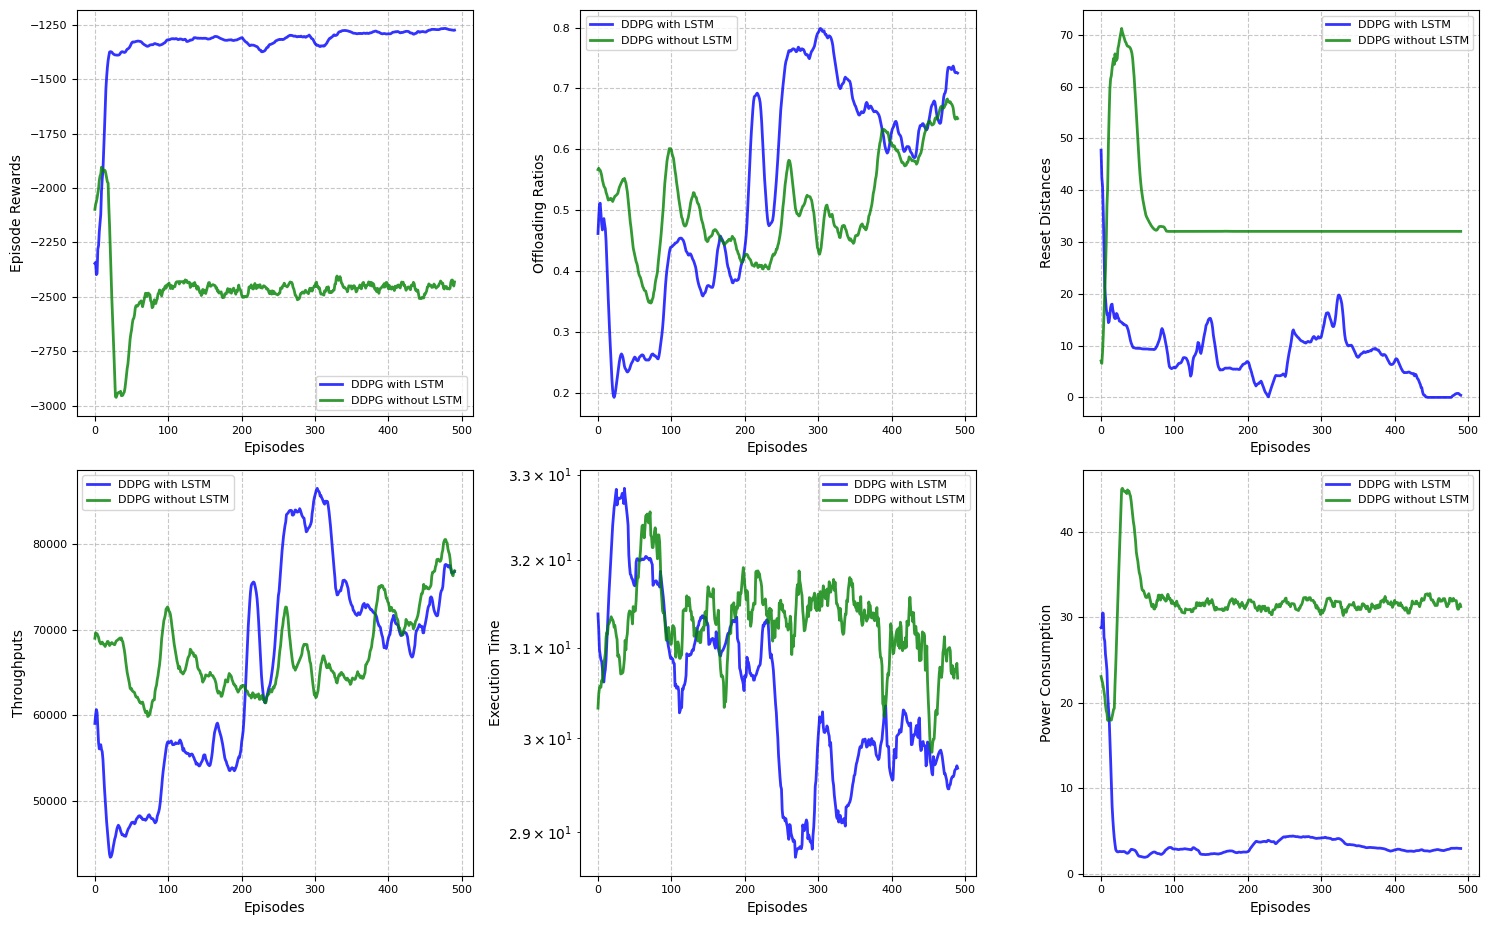

In [9]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Function to smooth data using a moving average
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Load data from the pickle files
with open('DDPG_with_LSTM_new.pkl', 'rb') as file:
    saved_lists_with_LSTM_2 = pickle.load(file)

with open('saved_lists_without_LSTM_new_.pkl', 'rb') as file:
    saved_lists_without_LSTM = pickle.load(file)

# Extract specific learning rate data (1e-4) for DDPG with LSTM
lr_key = '10^-0'
lstm_data = {
    metric: saved_lists_with_LSTM_2[metric][lr_key] 
    for metric in saved_lists_with_LSTM_2.keys()
}

# Define metrics for the two models
all_metrics = {
    'DDPG with LSTM': lstm_data,
    'DDPG without LSTM': saved_lists_without_LSTM
}

# Define plot combination for DDPG comparison
plot_combinations = {
    'DDPG_with_LSTM_vs_DDPG_without_LSTM': ['DDPG with LSTM', 'DDPG without LSTM']
}

# Define metric names with improved titles
metric_titles = {
    'episode_rewards': 'Episode Rewards',
    'episode_offloading_ratios': 'Offloading Ratios',
    'episode_reset_dists': 'Reset Distances',
    'episode_throughputs': 'Throughputs',
    'episode_Time_': 'Execution Time',
    'episode_power_': 'Power Consumption'
}

# Define colors for the two models
colors = {
    'DDPG with LSTM': 'blue',
    'DDPG without LSTM': 'green'
}

# Function to generate grid plot
def generate_grid_plot(combo_name, labels):
    metrics_to_plot = list(metric_titles.keys())
    n_metrics = len(metrics_to_plot)
    n_rows = 2
    n_cols = int(np.ceil(n_metrics / 2))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 10))
    
    if n_metrics > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, metric_name in enumerate(metrics_to_plot):
        ax = axes[idx]
        for label in labels:
            if metric_name in all_metrics[label]:
                data = all_metrics[label][metric_name]
                if len(data) >= 10:
                    smoothed_data = moving_average(data, window_size=10)
                    x = np.arange(len(smoothed_data))
                    ax.plot(x, smoothed_data, label=label, color=colors[label], 
                            linewidth=2, alpha=0.8)
                else:
                    ax.plot(data, label=label, color=colors[label], 
                            linewidth=2, alpha=0.8)
            else:
                print(f"Skipping {metric_name} for {label} as it does not exist.")
        
        # Customize subplot appearance
        ax.set_xlabel('Episodes', fontsize=10)
        ax.set_ylabel(metric_titles[metric_name], fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Use logarithmic scale for Execution Time
        if metric_name == 'episode_Time_':
            ax.set_yscale('log')
        
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Hide unused subplots
    for idx in range(n_metrics, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'grid_plot_{combo_name}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Generate the plot
for combo_name, labels in plot_combinations.items():
    generate_grid_plot(combo_name, labels)
